In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import pydotplus
from sklearn.datasets import load_iris
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
# 加载数据
iris = load_iris()
X = iris.data  # 特征矩阵 (150x4)
y = iris.target  # 标签 (0: setosa, 1: versicolor, 2: virginica)
feature_names = iris.feature_names  # 特征名 ['sepal length (cm)', ...]
target_names = iris.target_names    # 类别名 ['setosa', 'versicolor', 'virginica']

In [176]:
import pandas as pd
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df.head() 

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [178]:
x =iris_df.drop('target',axis = 1)
y =iris_df.target

In [180]:
x.shape

(150, 4)

In [182]:
y.shape

(150,)

In [184]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [186]:
x_train.shape

(105, 4)

In [188]:
x_test.shape

(45, 4)

In [190]:
#方法一 基模型训练，测试
base_model = DecisionTreeClassifier()#训练对象
base_model.fit(x_train, y_train)#训练
y_pred = base_model.predict(x_test)#预测
print('基模型的测试accuracy: %0.2f%%'%metrics.accuracy_score(y_test,y_pred))

基模型的测试accuracy: 1.00%


In [192]:
print('基模型默认参数',base_model.get_params())

基模型默认参数 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


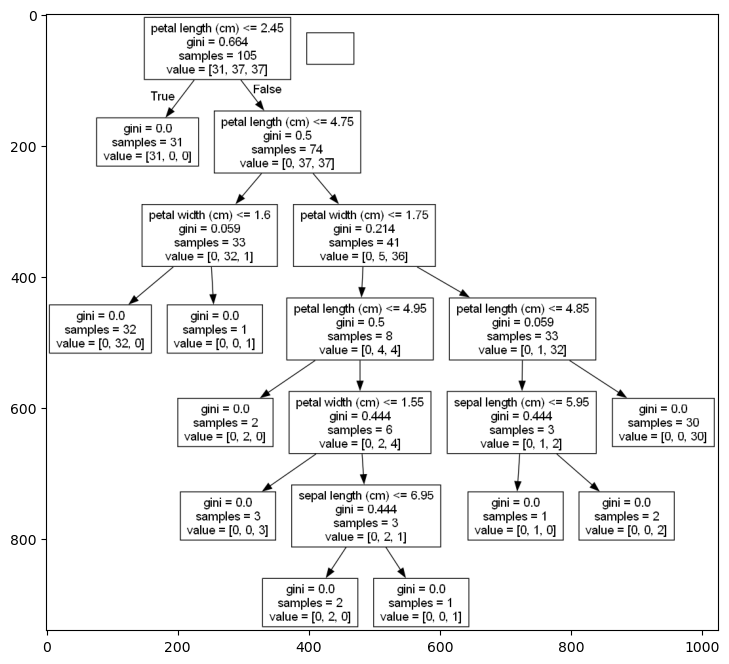

In [194]:
#可视化
data = tree.export_graphviz(base_model, feature_names=x_train.columns)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png('diabetes_data_model_png')
img = plt.imread('diabetes_data_model_png')
plt.figure(figsize=(10,8))
plt.imshow(img)

In [195]:
#方法2 调参模型2
tune_model = DecisionTreeClassifier(criterion="gini", max_depth=3, min_samples_leaf=3)
tune_model.fit(x_train, y_train)#训练
y_pred = tune_model.predict(x_test)#预测
print('基模型的测试accuracy: %0.2f%%'%metrics.accuracy_score(y_test,y_pred))

基模型的测试accuracy: 1.00%


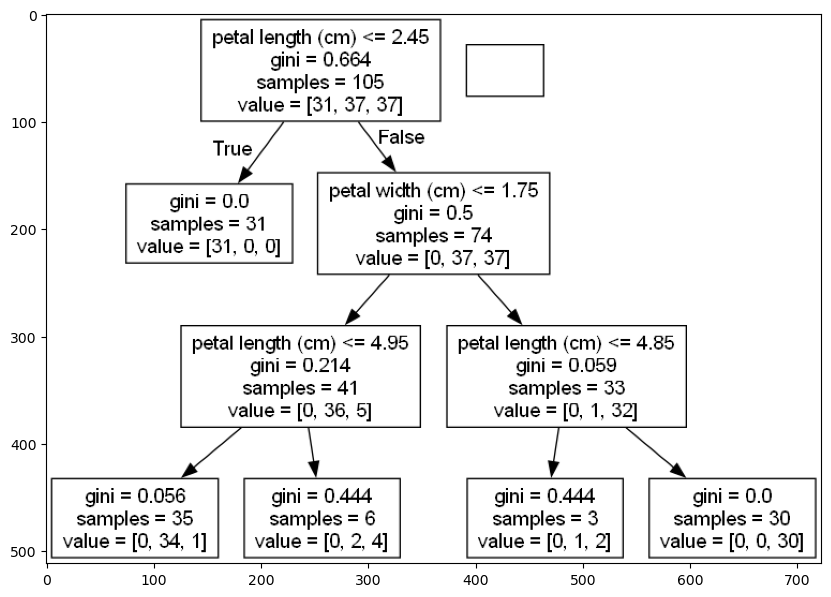

In [196]:
data = tree.export_graphviz(tune_model, feature_names=x_train.columns)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png('diabetes_tune_model_png')
img = plt.imread('diabetes_tune_model_png')
plt.figure(figsize=(10,8))
plt.imshow(img)

In [199]:
from sklearn.ensemble import RandomForestClassifier

#随机森林以及特征排序
#超参数调优 网格搜索
from sklearn.model_selection import GridSearchCV
# 初始化模型（设置随机种子保证可复现性）
rf1 = RandomForestClassifier(
     max_depth=10,
    random_state=42,  # 固定随机种子
    n_jobs=-1,       # 使用所有CPU核心加速
    max_features='sqrt'  # 默认特征选择方式
)

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],# 树数量（平衡性能与计算成本）
    'max_depth': [None, 10, 20],# 控制过拟合
    'min_samples_split': [2, 5, 10],# 节点最小分裂样本数
    'min_samples_leaf': [1, 2, 4], # 叶节点最小样本数
    'criterion': ['gini', 'entropy']# 分裂标准
}

# 网格搜索
grid_search = GridSearchCV(estimator=rf1,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy', 
                           n_jobs=-1,)
gs = grid_search.fit(x_train, y_train)

# 输出最佳参数
print("Best Parameters:", gs.best_params_)
print(gs.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.9428571428571428


In [203]:
#创建一个对象
rf2 = RandomForestClassifier(criterion='entropy',
                             max_depth=10,
                            min_samples_leaf=5,
                            min_samples_split=12,
                            n_estimators=50,
                            n_jobs=-1,
                            random_state=1)

In [205]:
#先训练一下
rf2.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=12, n_estimators=50, n_jobs=-1,
                       random_state=1)

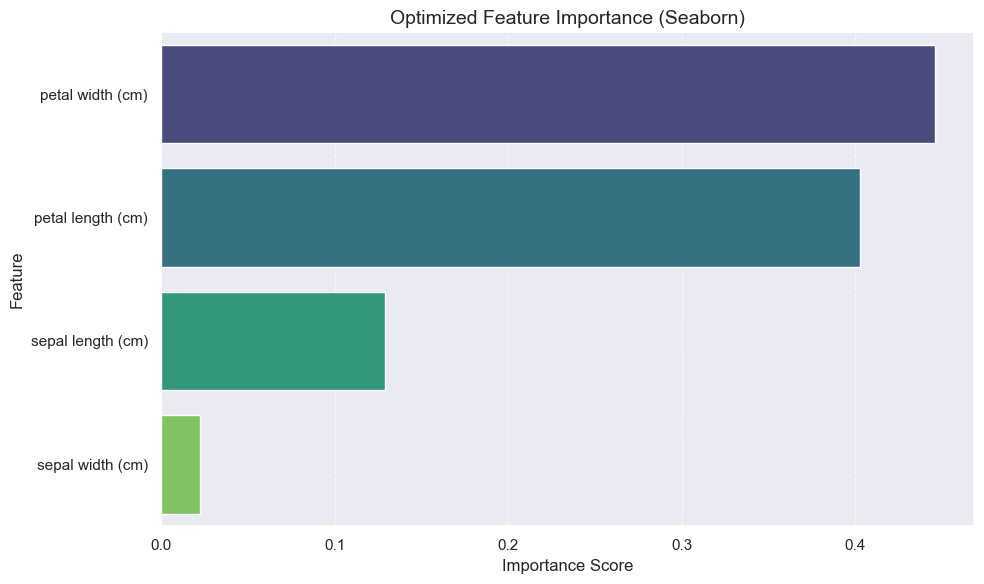

In [225]:
#运用seaborn代替matpolib增强色彩
import seaborn as sns
import matplotlib.pyplot as plt

# 创建DataFrame并排序
importance = pd.DataFrame({
    'Feature': x_test.columns,
    'Importance': rf2.feature_importances_
}).sort_values('Importance', ascending=False)  # 升序排序，确保图表从上到下重要性递增

# 使用Seaborn绘制竖向条形图
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    hue='Feature',  
    data=importance,
    palette='viridis',  # 颜色方案
    orient='h'          # 横向条形图（实际显示为竖向列表）
)
# 添加标题和标签
plt.title('Optimized Feature Importance (Seaborn)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)  # 添加横向网格线

plt.tight_layout()
plt.show()

In [289]:
#分类边界可视化
x_2d = x_train.iloc[:, [2, 3]]  # 花瓣长度 + 花瓣宽度 .iloc 转换为NumPy数组再切片
x_array = x_2d.values  # 转换为NumPy数组避免特征名警告
#重新训练简化模型（仅用这2个特征）
third_model = DecisionTreeClassifier(criterion="gini", max_depth=3,random_state=42)
third_model.fit(x_2d,y_train)

num_points = 100  # 每维网格点数
x_min, x_max = x_array[:, 0].min() - 1, x_array[:, 0].max() + 1  # 第一列范围
y_min, y_max = x_array[:, 1].min() - 1, x_array[:, 1].max() + 1  # 第二列范围
xx, yy = np.meshgrid(   # 在2个特征的定义域内生成网格
    np.linspace(x_min, x_max, num_points),  # 等间距划分
    np.linspace(y_min, y_max, num_points)
)
# 预测网格点类别
Z1 = third_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z1 = Z1.reshape(xx.shape)

D:\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


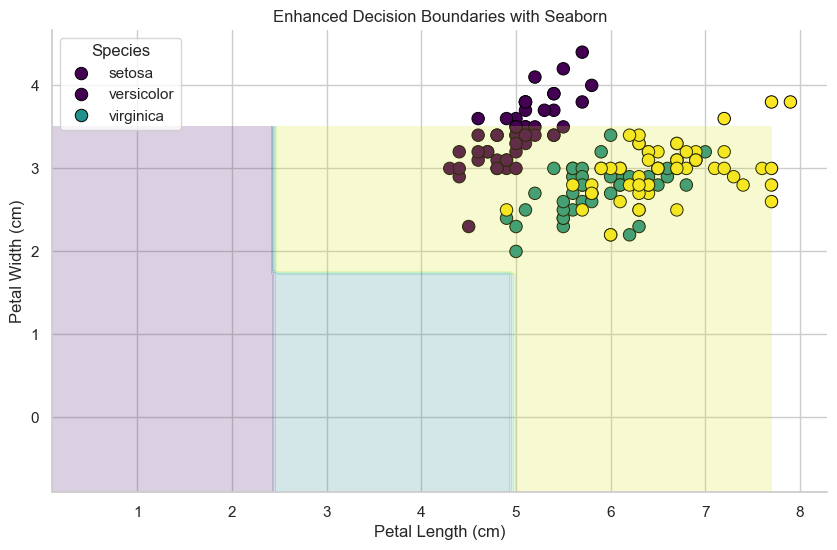

In [291]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x.iloc[:, 0], y=x.iloc[:, 1], hue=y, palette='viridis', edgecolor='black', s=80)
plt.contourf(xx, yy, Z1, alpha=0.2, cmap='viridis')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Enhanced Decision Boundaries with Seaborn')
plt.legend(title='Species', labels=iris.target_names)
sns.despine()
plt.show()

In [297]:
#重新训练简化模型（仅用这2个特征）
rf3 = RandomForestClassifier(criterion='entropy',
                             max_depth=10,
                            min_samples_leaf=5,
                            min_samples_split=12,
                            n_estimators=100,
                            n_jobs=-1,
                            random_state=1)
rf3.fit(x_2d,y_train)

num_points = 100  # 每维网格点数
x_min, x_max = x_array[:, 0].min() - 1,x_array[:, 0].max() + 1  # 第一列范围
y_min, y_max = x_array[:, 1].min() - 1,x_array[:, 1].max() + 1  # 第二列范围
xx, yy = np.meshgrid(   # 在2个特征的定义域内生成网格
    np.linspace(x_min, x_max, num_points),  # 等间距划分
    np.linspace(y_min, y_max, num_points)
)
# 预测网格点类别
Z2 = rf3.predict(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z2.reshape(xx.shape)

D:\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


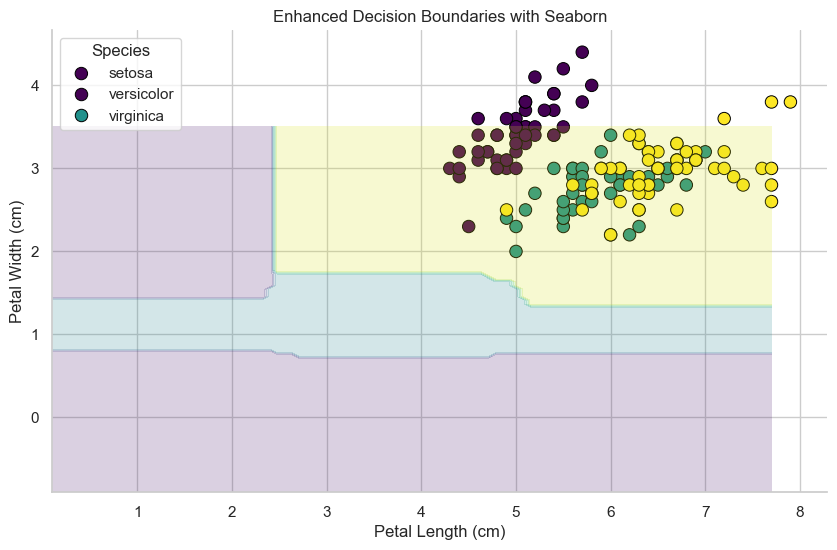

In [299]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x.iloc[:, 0], y=x.iloc[:, 1], hue=y, palette='viridis', edgecolor='black', s=80)
plt.contourf(xx, yy, Z2, alpha=0.2, cmap='viridis')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Enhanced Decision Boundaries with Seaborn')
plt.legend(title='Species', labels=iris.target_names)
sns.despine()
plt.show()

D:\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


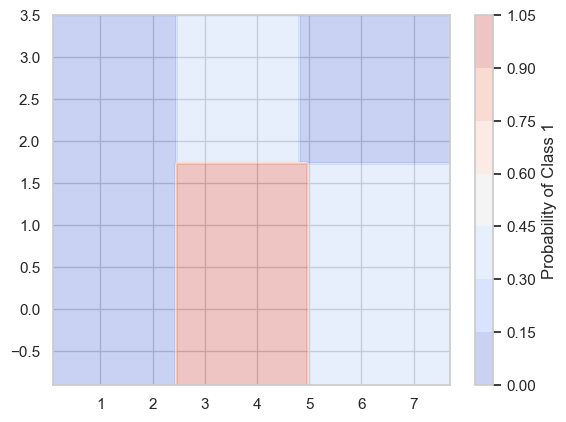

In [303]:
# 生成网格点概率
Z_proba = third_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]  # 取类别1的概率
Z_proba = Z_proba.reshape(xx.shape)

# 绘制概率热力图
plt.contourf(xx, yy, Z_proba, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Probability of Class 1')

D:\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


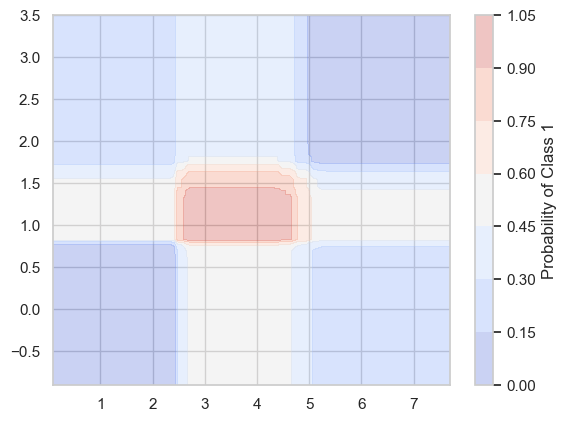

In [305]:
# 生成网格点概率
Z_proba = rf3.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]  # 取类别1的概率
Z_proba = Z_proba.reshape(xx.shape)

# 绘制概率热力图
plt.contourf(xx, yy, Z_proba, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Probability of Class 1')